## 1. Introdução

Neste notebook você encontrará uma análise exploratória de dados (EDA) de um dataset contendo informações de desempenho escolar de alunos da rede de ensino brasileira.

O objetivo dessa análise é:

- Identificar a relação entre os índices de desempenho e aprovação com as demais variáveis.
- Encontrar padrões que revelem pontos fracos na rede de ensino nacional.
- Levantar hipóteses e sugestões sobre como combater ou remediar os problemas identificados.

O dados utilizados nessa análise foram coletados pelo Instituto Nacional de Estudos e Pesquisas Educacionais (Inep) e fornecidos pela ONG Base dos Dados. O dataset pode ser acessado pelo Big Query [aqui](https://console.cloud.google.com/bigquery?p=basedosdados&d=br_inep_ideb&t=brasil&page=table&project=nimble-volt-461222-e1).

## 2. Importação e Limpeza dos dados

In [3]:
#Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import basedosdados as bd
import seaborn as sns

#Importando dados

billing_id = 'nimble-volt-461222-e1'

query = """
  SELECT
    dados.ano as ano,
    dados.rede as rede,
    dados.ensino as ensino,
    dados.anos_escolares as anos_escolares,
    dados.taxa_aprovacao as taxa_aprovacao,
    dados.ideb as ideb
FROM `basedosdados.br_inep_ideb.brasil` AS dados
"""

df = bd.read_sql(query = query, billing_project_id = billing_id)

Downloading: 100%|██████████|


In [4]:
#Cópia dos dados 
df.to_csv('data/inep.csv', index=False)

In [5]:
#Visão geral
df.head()

,ano,rede,ensino,anos_escolares,taxa_aprovacao,ideb
0,2005,privada,medio,todos (1-4),92.7,5.6
1,2005,estadual,medio,todos (1-4),70.5,3.0
2,2005,total,medio,todos (1-4),73.2,3.4
3,2005,publica,medio,todos (1-4),70.6,3.1
4,2005,total,fundamental,finais (6-9),77.0,3.5


In [6]:
#Tamanho da base
print(f"Linhas: {df.shape[0]} Colunas: {df.shape[1]}")

Linhas: 140 Colunas: 6


In [7]:
#Explorando a categoria "todos(1-4)" da base
df.loc[(df['anos_escolares'] == 'todos (1-4)') & (df['ano'] == 2023)]

,ano,rede,ensino,anos_escolares,taxa_aprovacao,ideb
126,2023,privada,medio,todos (1-4),97.1,5.6
127,2023,estadual,medio,todos (1-4),90.5,4.1
128,2023,total,medio,todos (1-4),91.3,4.3
129,2023,publica,medio,todos (1-4),90.5,4.1


Os registros 'todos (1-4)' na realidade se tratam dos anos do ensino médio, ainda contabilizando pela época em que haviam 4 anos no ensino médio. Para evitar confusão com os rótulos, irei alterar o nome desses registros.

In [8]:
df['anos_escolares'] = df['anos_escolares'].apply(lambda x: "medio_todos (1-3)" if x == 'todos (1-4)' else x)

In [9]:
#Valores nulos
print(df.isnull().sum())
print("\nNão temos valores nulos\n")


#Cópia dos dados normalizados
df.to_csv('data/inep_normalizado.csv', index=False)

ano               0
rede              0
ensino            0
anos_escolares    0
taxa_aprovacao    0
ideb              0
dtype: int64

Não temos valores nulos



In [10]:
df.head()

,ano,rede,ensino,anos_escolares,taxa_aprovacao,ideb
0,2005,privada,medio,medio_todos (1-3),92.7,5.6
1,2005,estadual,medio,medio_todos (1-3),70.5,3.0
2,2005,total,medio,medio_todos (1-3),73.2,3.4
3,2005,publica,medio,medio_todos (1-3),70.6,3.1
4,2005,total,fundamental,finais (6-9),77.0,3.5


## 3. Análise Exploratória

In [11]:
#Estatísticas quantitativas gerais
df.describe()

,ano,taxa_aprovacao,ideb
count,140.0,140.000000,140.000000
mean,2014.0,88.180000,4.737143
std,5.76519,7.948397,1.069818
min,2005.0,70.500000,3.000000
25%,2009.0,81.675000,3.800000
50%,2014.0,90.100000,4.600000
75%,2019.0,94.725000,5.700000
max,2023.0,99.300000,7.200000


In [12]:
#Estatísticas qualitativas gerais
df.describe(include='object')

,rede,ensino,anos_escolares
count,140,140,140
unique,5,2,3
top,privada,fundamental,finais (6-9)
freq,30,100,50


### 3.1 Panorama recente 

In [13]:
#Filtrando pelo ano mais recente presente na base
df_2023 = df[df['ano'] == 2023]

#### 3.1.1 Média de IDEB por rede de ensino

In [14]:
#Estilizando gráficos
sns.set_style("whitegrid")
sns.set_palette("crest")

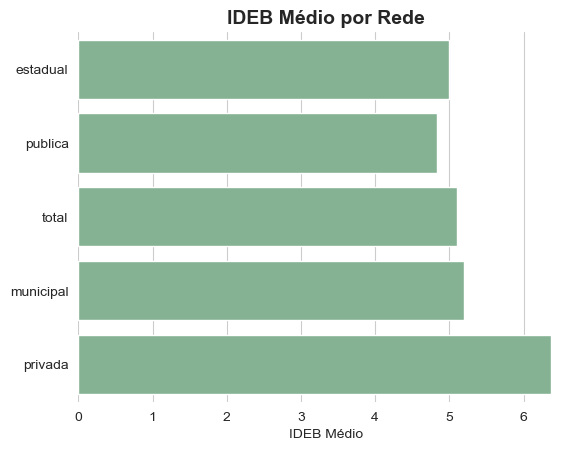

In [15]:
sns.barplot(data=df_2023.sort_values(by='ideb'), y='rede', x='ideb', ci=None)
plt.ylabel("")
plt.xlabel("IDEB Médio")
plt.title("IDEB Médio por Rede", fontsize= 14, weight='bold')
sns.despine(left=True, bottom=True)
plt.show()

#### 3.1.2 Taxa de Aprovação por rede de ensino

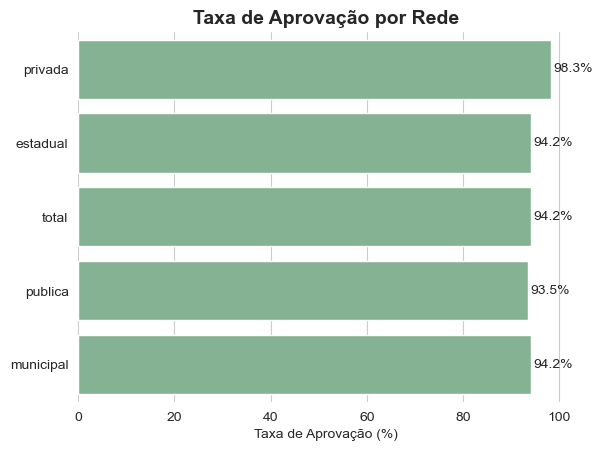

In [16]:

ax = sns.barplot(data=df_2023, x='taxa_aprovacao', y='rede',  ci=None)
plt.title("Taxa de Aprovação por Rede", fontsize= 14, weight='bold')
plt.xlabel("Taxa de Aprovação (%)")
plt.ylabel("")
sns.despine(left=True, bottom=True)


for p in ax.patches:
    ax.text(
        p.get_width() + 0.5,              
        p.get_y() + p.get_height()/2,     
        f"{p.get_width():.1f}%",          
        va="center", fontsize=10
    )

plt.show()

#### 3.1.3 Média de IDEB por ensino

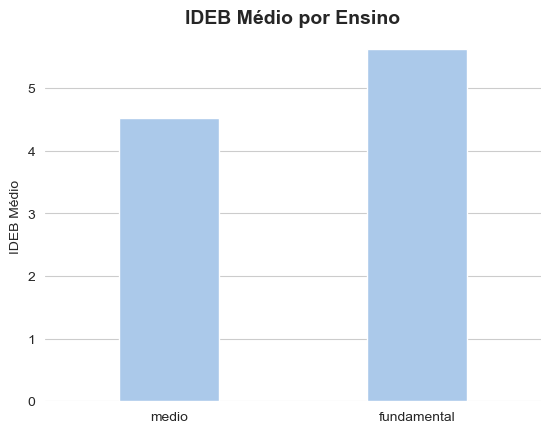

In [17]:
sns.set_palette("pastel")
sns.barplot(data=df_2023.sort_values(by='ideb'), x='ensino', y='ideb', ci=None, width=0.4)
plt.ylabel("IDEB Médio")
plt.xlabel("")
plt.title("IDEB Médio por Ensino",fontsize= 14, weight='bold')
sns.despine(left=True, bottom=True)
plt.show()

#### 3.1.3 Taxa de Aprovação por ensino

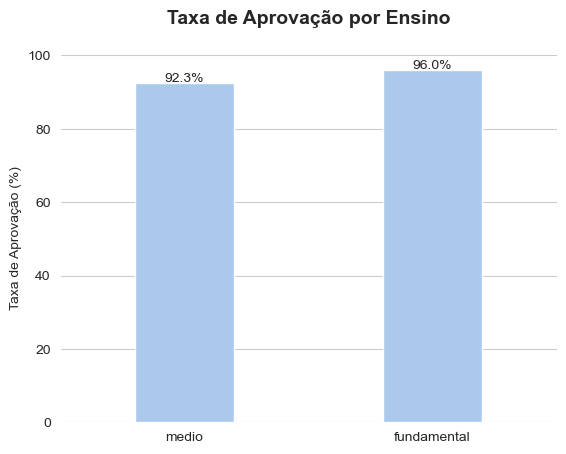

In [18]:
ax = sns.barplot(data=df_2023, x='ensino', y='taxa_aprovacao', ci=None, width=0.4)
plt.title("Taxa de Aprovação por Ensino\n", fontsize= 14, weight='bold')
plt.xlabel("")
plt.ylabel("Taxa de Aprovação (%)")
sns.despine(left=True, bottom=True)


for p in ax.patches:
    ax.text(
        x=p.get_x() + p.get_width() / 2,  
        y=p.get_height() + 0.5,           
        s=f"{p.get_height():.1f}%",       
        ha='center'                       
    )

plt.show()

#### 3.1.4 IDEB Médio por anos escolares

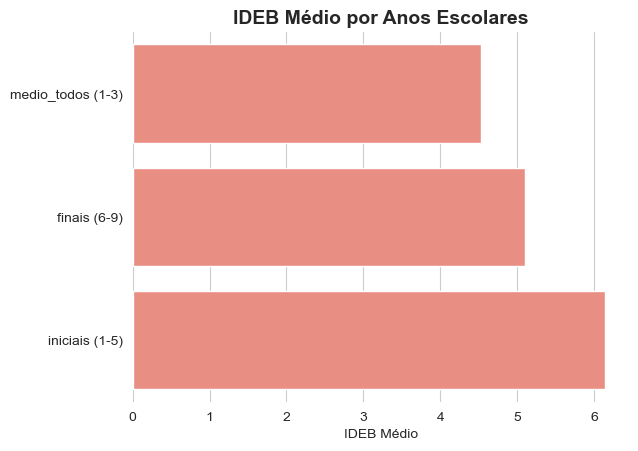

In [19]:
sns.barplot(data=df_2023.sort_values(by='ideb'), y='anos_escolares', x='ideb', ci=None, color='salmon')
plt.ylabel("")
plt.xlabel("IDEB Médio")
plt.title("IDEB Médio por Anos Escolares", fontsize= 14, weight='bold')
sns.despine(left=True, bottom=True) 

#### 3.1.5 Taxa de Aprovação por anos escolares

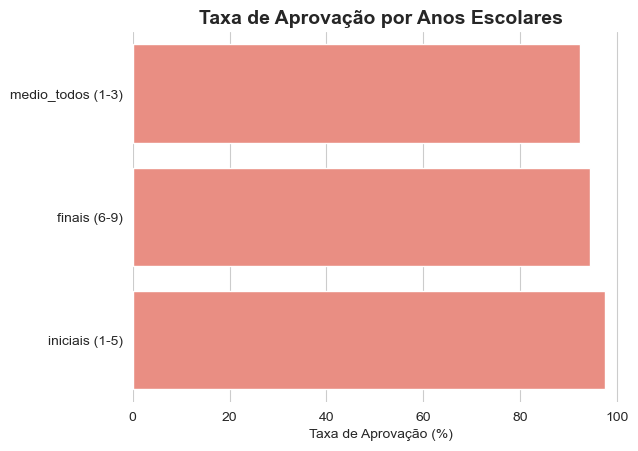

In [20]:
sns.barplot(data=df_2023.sort_values(by='ideb'), y='anos_escolares', x='taxa_aprovacao', ci=None, color='salmon')
plt.ylabel("")
plt.xlabel("Taxa de Aprovação (%)")
plt.title("Taxa de Aprovação por Anos Escolares", fontsize= 14, weight='bold')
sns.despine(left=True, bottom=True)
plt.show()

### 3.2 Análise histórica

#### 3.2.1 IDEB por rede de ensino

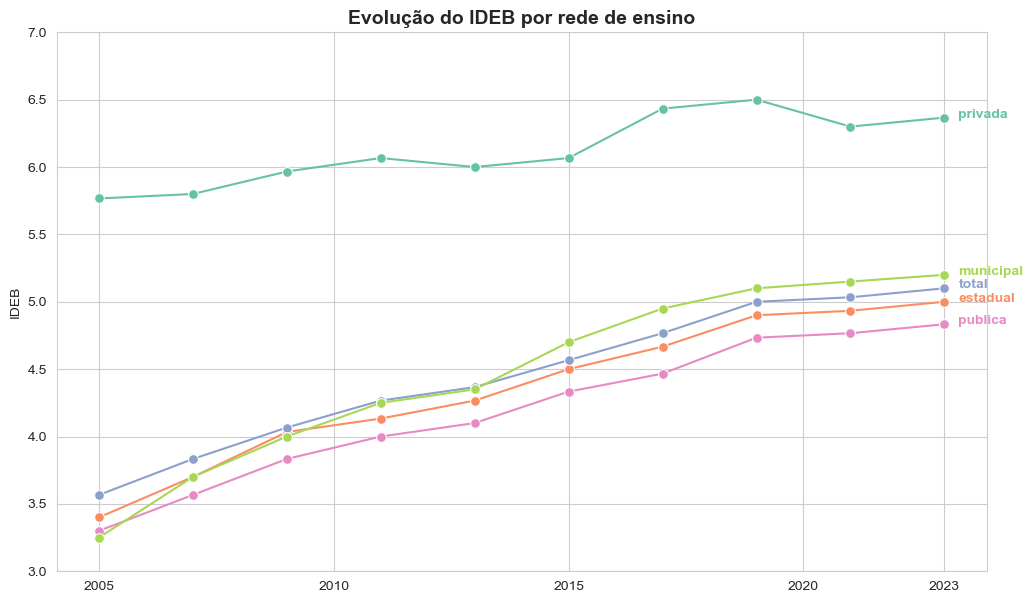

In [58]:
sns.set_palette("Set2")
plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df, x='ano', y='ideb', hue='rede', marker='o', ci=None,  linewidth=1.5, markersize=7)
ax.set_xticks([2005, 2010, 2015, 2020, 2023])
ax.set_ylim(3, 7)
ax.legend_.remove()
plt.title("Evolução do IDEB por rede de ensino", fontsize= 14, weight='bold')
plt.xlabel("")
plt.ylabel("IDEB")

for line, name in zip(ax.lines, df['rede'].unique()):
    x = line.get_xdata()[-1]  # último ano
    y = line.get_ydata()[-1]  # último valor
    ax.text(x+0.3, y, name, fontsize=10, weight='bold', color=line.get_color())

plt.show()

#### 3.2.2 Taxa de Aprovação por rede de ensino

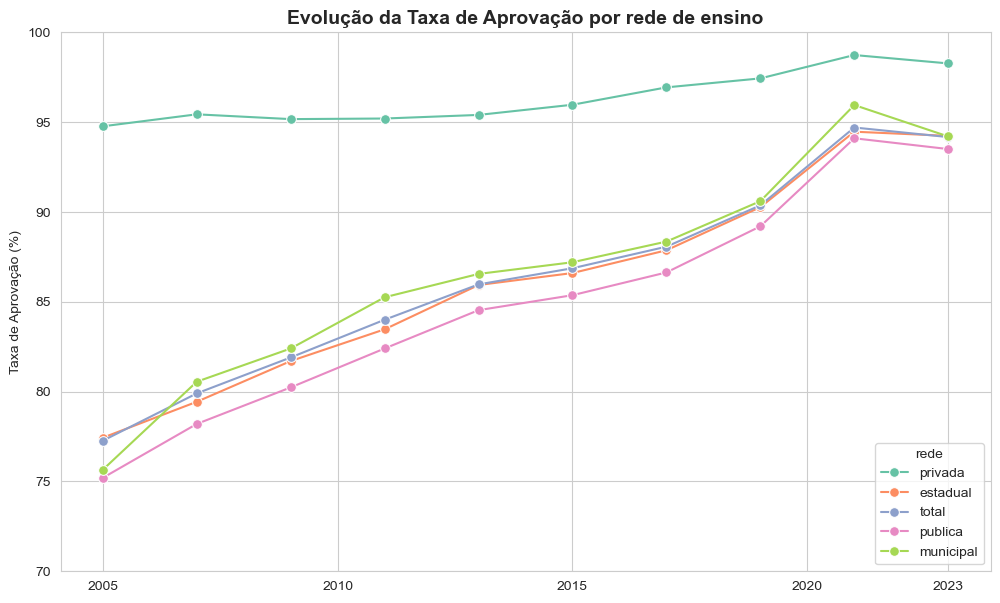

In [57]:
sns.set_palette("Set2")
plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df, x='ano', y='taxa_aprovacao', hue='rede', marker='o', ci=None,  linewidth=1.5, markersize=7)
ax.set_xticks([2005, 2010, 2015, 2020, 2023])
ax.set_ylim(70, 100)
plt.title("Evolução da Taxa de Aprovação por rede de ensino", fontsize= 14, weight='bold')
plt.xlabel("")
plt.ylabel("Taxa de Aprovação (%)")
plt.show()

#### 3.2.3 IDEB por nível de ensino

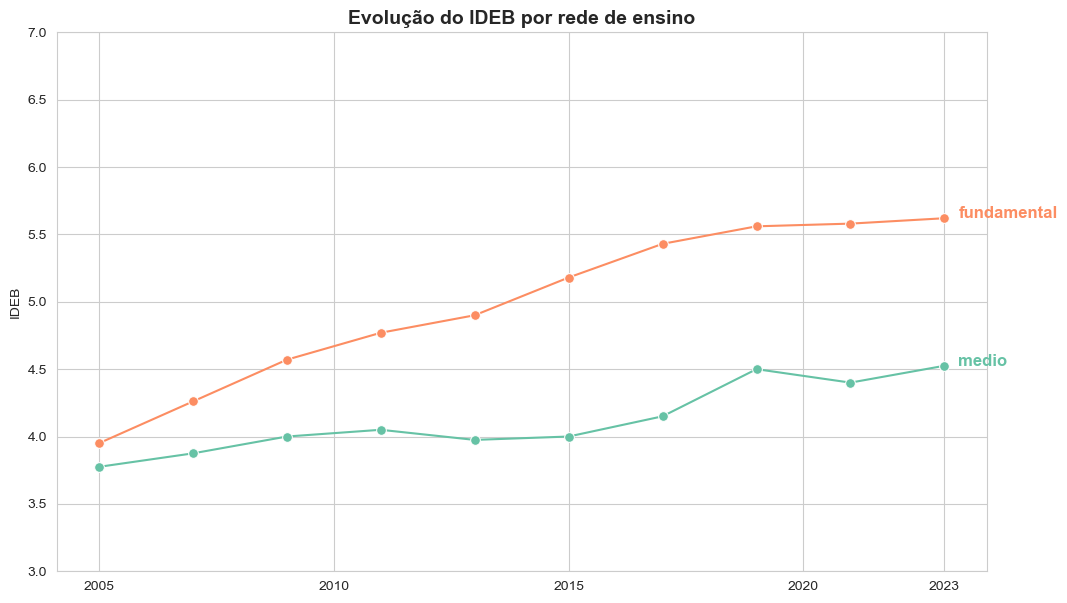

In [81]:
sns.set_palette("Set2")
plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df, x='ano', y='ideb', hue='ensino', marker='o', ci=None,  linewidth=1.5, markersize=7)
ax.set_xticks([2005, 2010, 2015, 2020, 2023])
ax.set_ylim(3, 7)
ax.legend_.remove()
plt.title("Evolução do IDEB por rede de ensino", fontsize= 14, weight='bold')
plt.xlabel("")
plt.ylabel("IDEB")

for line, name in zip(ax.lines, df['ensino'].unique()):
    x = line.get_xdata()[-1]
    y = line.get_ydata()[-1]
    ax.text(x+0.3, y, name, fontsize=12, weight='bold', color=line.get_color())

plt.show()

#### 3.2.4 Taxa de Aprovação por nível de ensino

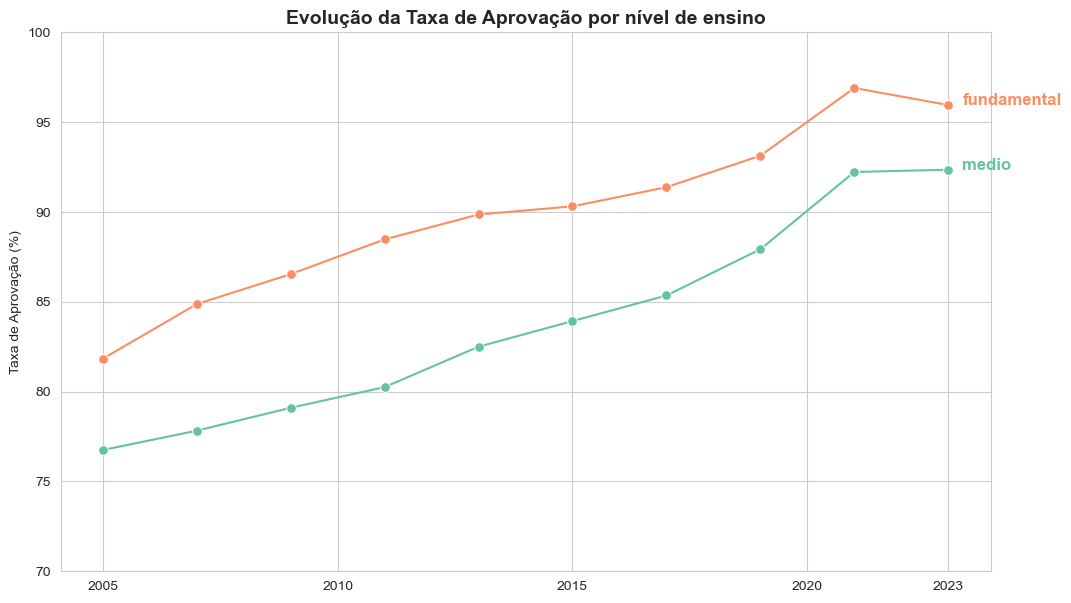

In [88]:
plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df, x='ano', y='taxa_aprovacao', hue='ensino', marker='o', ci=None,  linewidth=1.5, markersize=7)
ax.set_xticks([2005, 2010, 2015, 2020, 2023])
ax.set_ylim(70, 100)
plt.title("Evolução da Taxa de Aprovação por nível de ensino", fontsize= 14, weight='bold')
plt.xlabel("")
plt.ylabel("Taxa de Aprovação (%)")
ax.legend_.remove()
for line, name in zip(ax.lines, df['ensino'].unique()):
    x = line.get_xdata()[-1]
    y = line.get_ydata()[-1]
    ax.text(x+0.3, y, name, fontsize=12, weight='bold', color=line.get_color())
plt.show()

#### 3.2.5 IDEB por Anos escolares

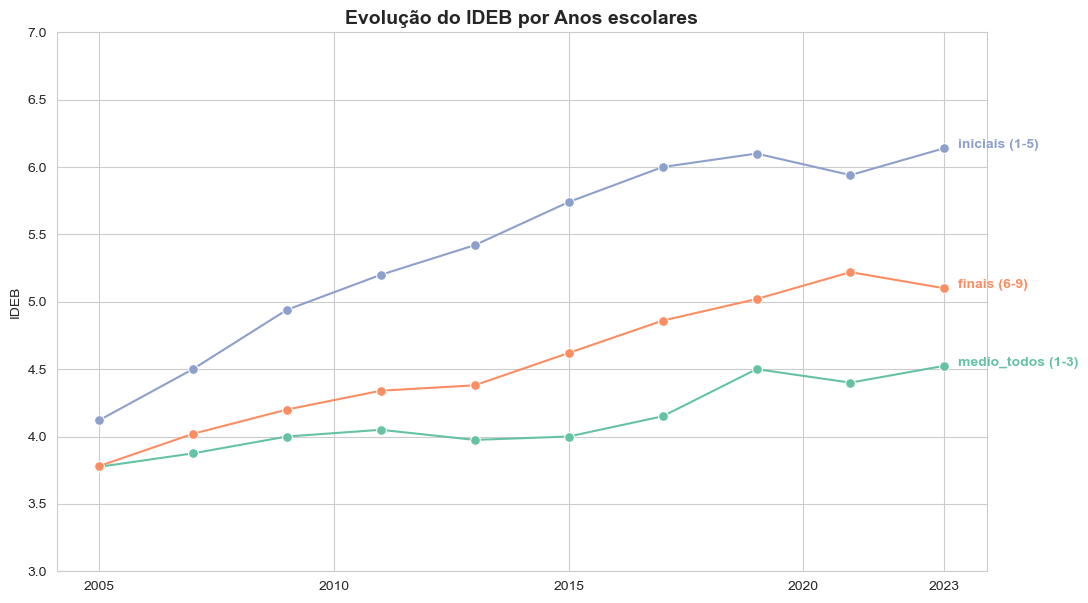

In [ ]:
plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df, x='ano', y='ideb', hue='anos_escolares', marker='o', ci=None,  linewidth=1.5, markersize=7)
ax.set_xticks([2005, 2010, 2015, 2020, 2023])
ax.set_ylim(3, 7)
ax.legend_.remove()
plt.title("Evolução do IDEB por Anos escolares", fontsize= 14, weight='bold')
plt.xlabel("")
plt.ylabel("IDEB")
for line, name in zip(ax.lines, df['anos_escolares'].unique()):
    x = line.get_xdata()[-1]  
    y = line.get_ydata()[-1]  
    ax.text(x+0.3, y, name, fontsize=10, weight='bold', color=line.get_color())
plt.show()

#### 3.2.6 Taxa de Aprovação por Anos escolares

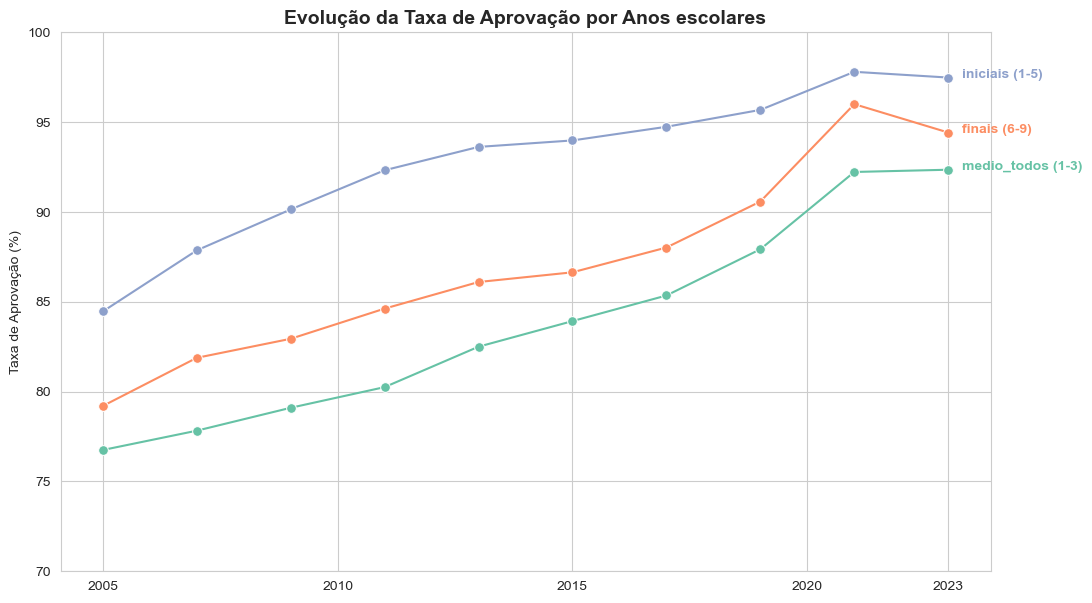

In [101]:
plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df, x='ano', y='taxa_aprovacao', hue='anos_escolares', marker='o', ci=None, linewidth=1.5, markersize=7)
ax.set_xticks([2005, 2010, 2015, 2020, 2023])
ax.set_ylim(70, 100)
plt.title("Evolução da Taxa de Aprovação por Anos escolares", fontsize= 14, weight='bold')
plt.xlabel("")
plt.ylabel("Taxa de Aprovação (%)")
ax.legend_.remove()
for line, name in zip(ax.lines, df['anos_escolares'].unique()):
    x = line.get_xdata()[-1]
    y = line.get_ydata()[-1]
    ax.text(x+0.3, y, name, fontsize=10, weight='bold', color=line.get_color())
plt.show()

